**Загрузка данных с Kaggle**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goraskochilov","key":"39d109cdc54a869562ae049f6195bfc7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download adityakadiwal/water-potability -f water_potability.csv

Dataset URL: https://www.kaggle.com/datasets/adityakadiwal/water-potability
License(s): CC0-1.0
  0% 0.00/513k [00:00<?, ?B/s]
100% 513k/513k [00:00<00:00, 109MB/s]


**Импортируем библиотеки**

In [23]:
#Основные библиотеки
import pandas as pd
import numpy as np

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#Предобработка
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

#Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Метрики
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

#Сохранение модели
import joblib

In [6]:
#Загрузка данных
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Замечаем пропущенные значения: ph NaN и Sulfate NaN, с ними разберемся позже

In [7]:
#Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Всего 3276 записей и 10 столбцов, один из которых наш целевой признак (Potability)

Potability
0    1998
1    1278
Name: count, dtype: int64


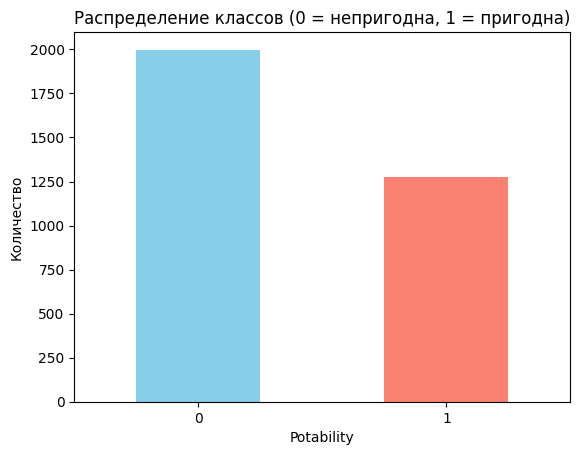

In [8]:
#Распределение Potability
print(df['Potability'].value_counts())
df['Potability'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов (0 = непригодна, 1 = пригодна)')
plt.xlabel('Potability')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

Как мы видим классы немного несбалансированны: ~2000 непригодны и ~1250 пригодны

**Подготовка данных**

In [9]:
print("Пропущенные значения:")
print(df.isnull().sum())

Пропущенные значения:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


Как мы заметили раньше, в данных присутсвуют пропущенные значения. Заполним их медианой по каждому признаку

In [10]:
#Заполнение пропусков медианой
df['ph'] = df['ph'].fillna(df['ph'].median())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].median())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].median())

print("После заполнения:")
print(df.isnull().sum())

После заполнения:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


**Рассмотрим распределение признаков и построим корреляционную матрицу**

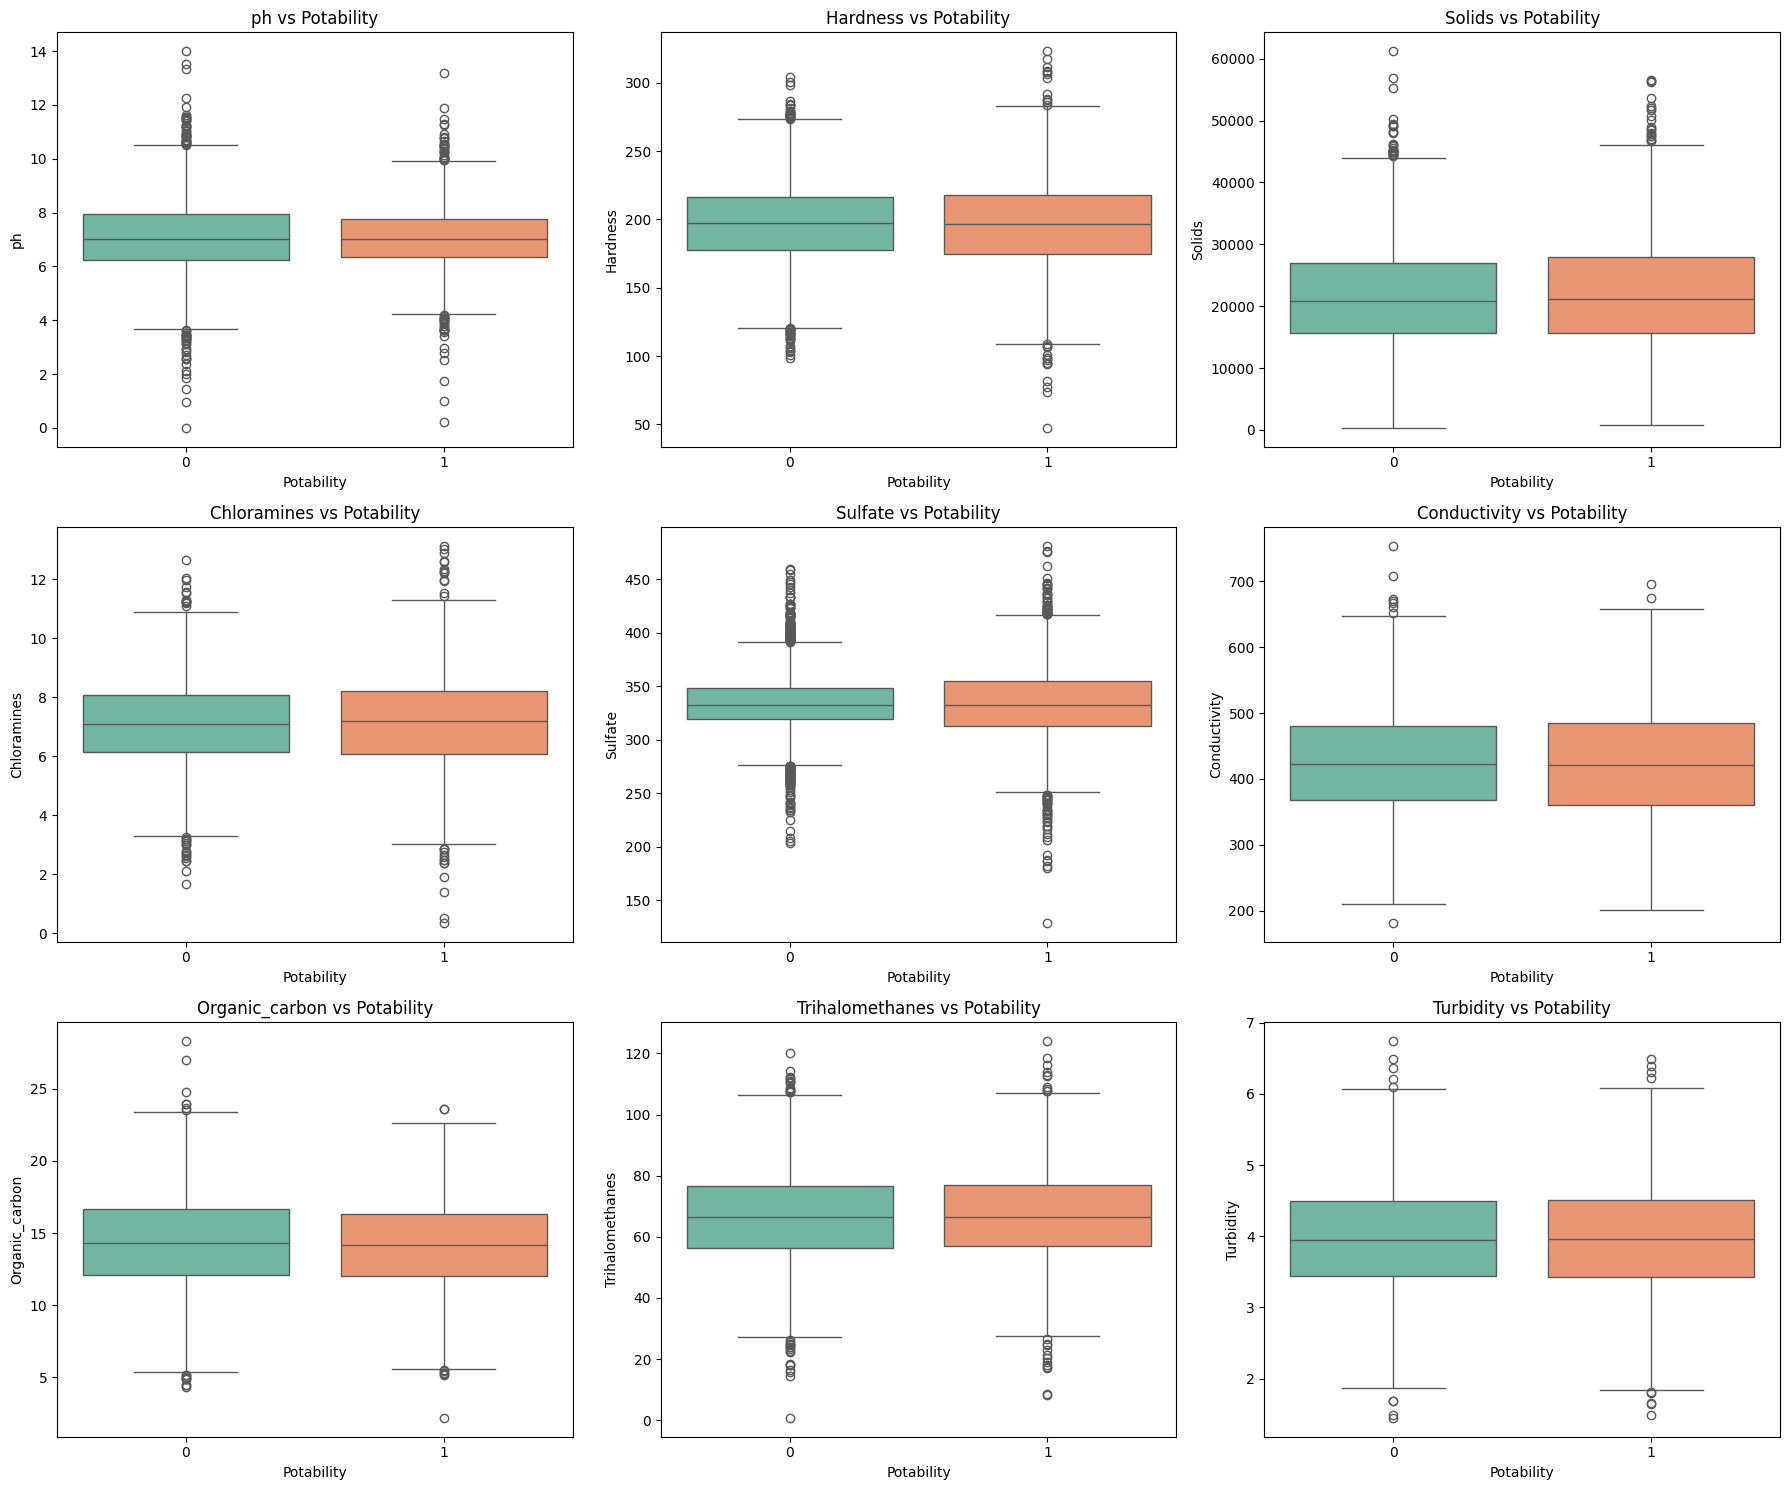

In [11]:
#Построим boxplot для каждого признака по Potability
features = df.columns.drop('Potability')
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(
        x='Potability',
        y=col,
        hue='Potability',
        data=df,
        ax=axes[i],
        palette='Set2',
        legend=False
    )
    axes[i].set_title(f'{col} vs Potability')

#Удалим пустые subplot'ы
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

По графикам распределения признаков видно небольшое отличие признаков при Potability = 0 и Potability = 1.  
Наши признаки "накладываются друг на друга", построим графики распределения, для более подробного рассмотрения

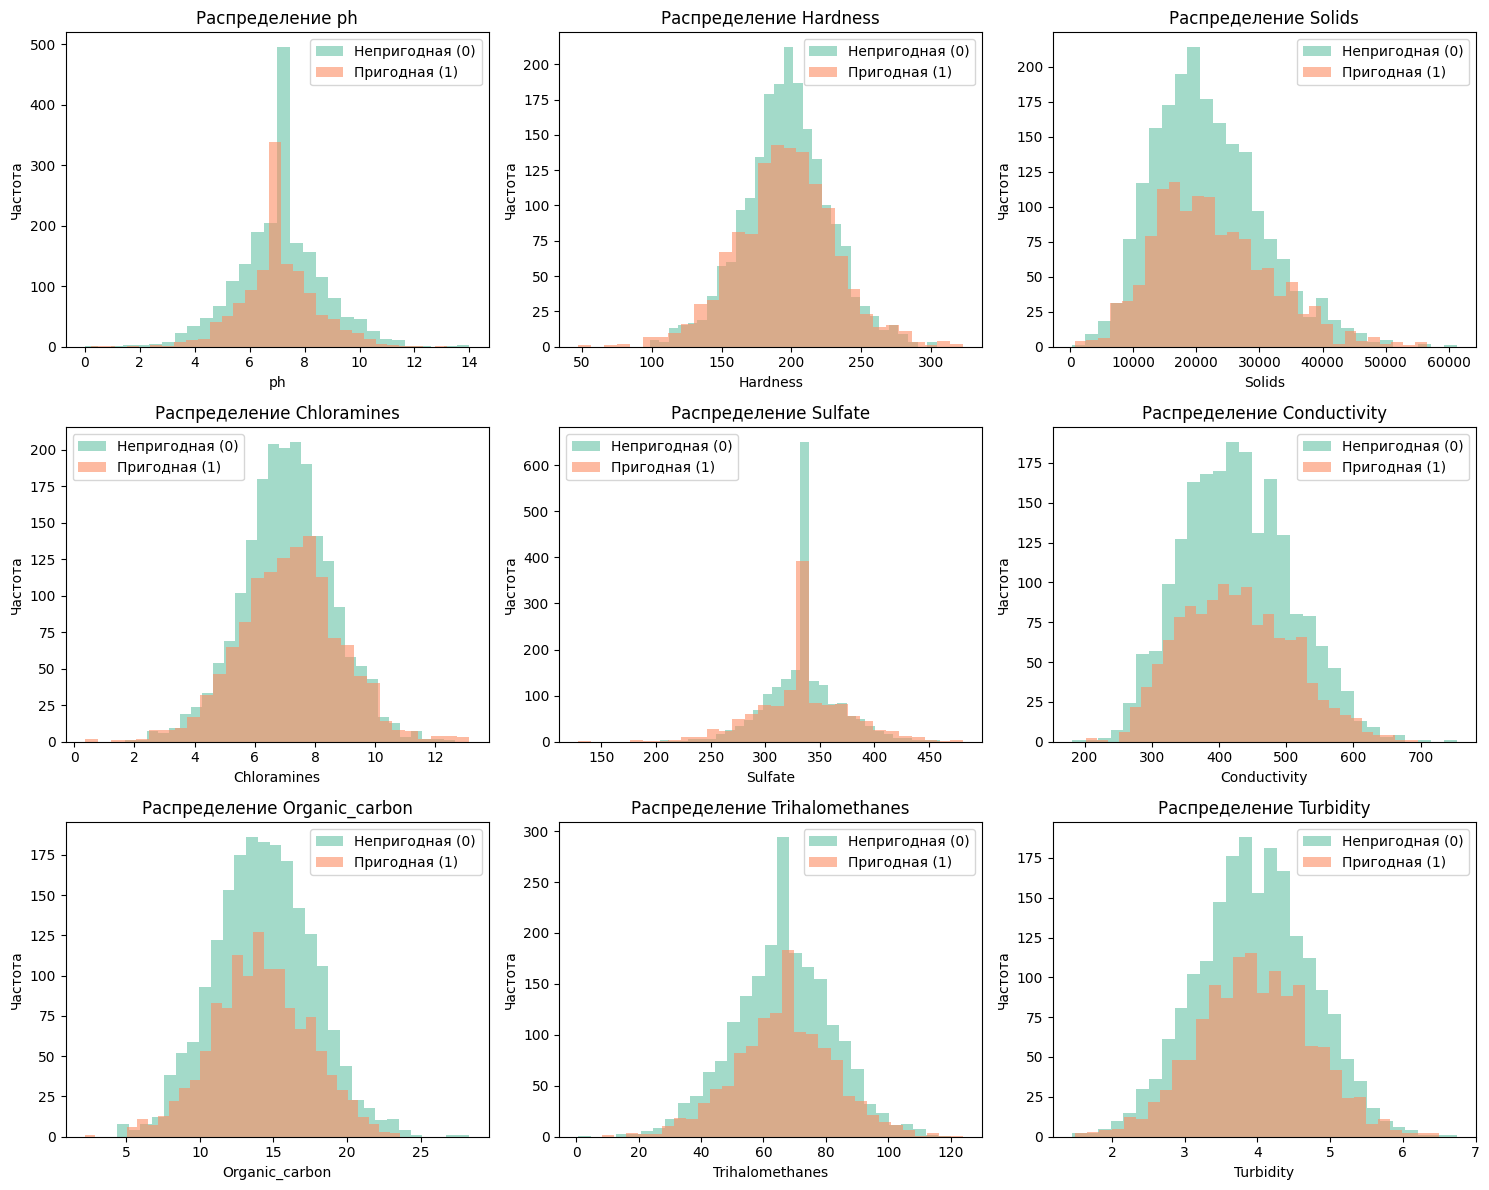

In [12]:
colors = sns.color_palette('Set2', n_colors=2)
color_class_0 = colors[0]
color_class_1 = colors[1]

n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)

    plt.hist(
        df[df['Potability'] == 0][feature],
        bins=30,
        alpha=0.6,
        label='Непригодная (0)',
        color=color_class_0
    )

    plt.hist(
        df[df['Potability'] == 1][feature],
        bins=30,
        alpha=0.6,
        label='Пригодная (1)',
        color=color_class_1
    )

    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.title(f'Распределение {feature}')
    plt.legend()

plt.tight_layout()
plt.show()


Такова особенность данных , и к сожалению, они приводит к уменьшению точности предсказательной модели

Рассмотрим корреляционную матрицу

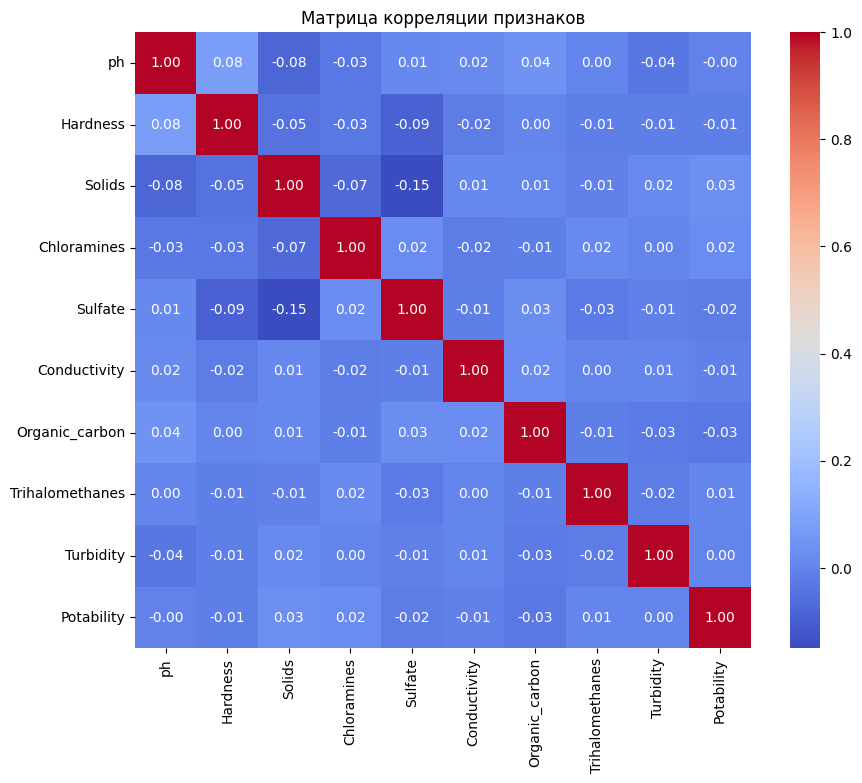

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляции признаков')
plt.show()

По матрице видно, что признаки слабо коррелированы, что дает нам понять, что в наших данных признаки отвечают за разные аспекты качества воды

**Разделим и маштабируем данные**

In [14]:
#Разделение на признаки и целевую переменную
X = df.drop('Potability', axis=1)
y = df['Potability']

#Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Масштабирование (для моделей, чувствительных к масштабу, в нашем случае LR и kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Определим функцию оценки и обучим несколько моделей**

Сначала определим функцию для оценки моделей

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, needs_proba=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Основные метрики
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    #ROC-AUC
    if needs_proba:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = None

    print(f"\n=== {model_name} ===")
    print(f"Precision (class=1): {prec:.4f}")
    print(f"Recall (class=1)   : {rec:.4f}")
    print(f"F1-score (class=1) : {f1:.4f}")
    if auc is not None:
        print(f"ROC-AUC            : {auc:.4f}")

    #Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Potable (0)', 'Potable (1)'],
                yticklabels=['Not Potable (0)', 'Potable (1)'])
    plt.title(f'Confusion Matrix — {model_name}')
    plt.ylabel('Истинные')
    plt.xlabel('Предсказанные')
    plt.show()

    return {
        'model': model_name,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': auc
    }

Теперь обучим сами модели

Для Random Forest и XFBoost используем немасшабируемые данные, так как деревья инвариантны к масштабу признаков — им всё равно, в каких единицах измерения значения.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression ===
Precision (class=1): 0.0000
Recall (class=1)   : 0.0000
F1-score (class=1) : 0.0000
ROC-AUC            : 0.5481


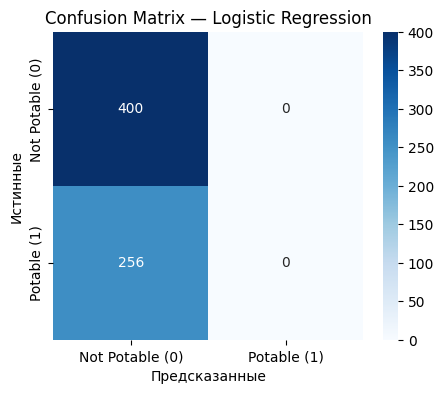


=== Random Forest ===
Precision (class=1): 0.6311
Recall (class=1)   : 0.3008
F1-score (class=1) : 0.4074
ROC-AUC            : 0.6407


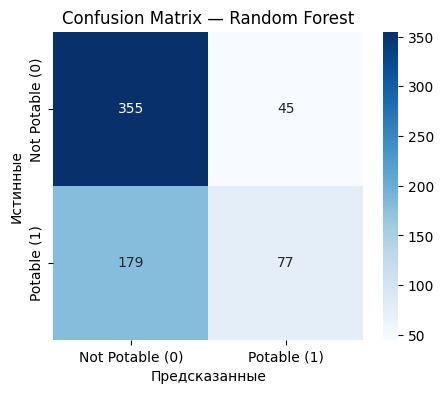

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:40:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Precision (class=1): 0.5574
Recall (class=1)   : 0.3984
F1-score (class=1) : 0.4647
ROC-AUC            : 0.6256


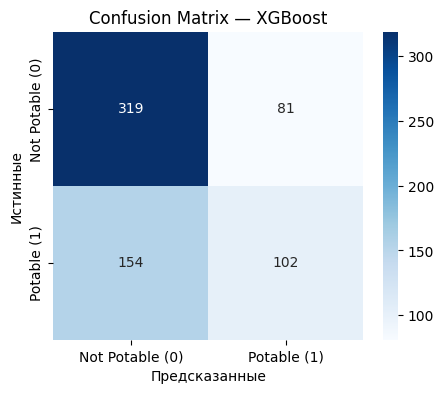


=== k-NN ===
Precision (class=1): 0.5093
Recall (class=1)   : 0.3203
F1-score (class=1) : 0.3933
ROC-AUC            : 0.5978


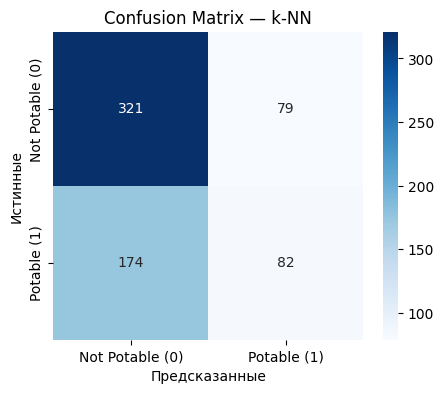

In [16]:
results = []

#Логистическая регрессия
lr = LogisticRegression(random_state=42, max_iter=1000)
results.append(evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"))

#Random Forest
rf = RandomForestClassifier(random_state=42)
results.append(evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest"))

#XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
results.append(evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost"))

#k-NN
knn = KNeighborsClassifier(n_neighbors=5)
results.append(evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test, "k-NN"))

Как мы видим, Логистическая регрессия вообще вообще не предсказала ни одного объекта как класс 1. Так произошло из-за дисбаланса классов, попробуем это исправить, а заодно улучшить другие модели

Попробуем улучшить модели путем добавления
```
class_weight='balanced'
```
Что должно убрать дисбаланс  
Для XGBoost так не получится, поэтому воспользуемся

```
scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
```
Что делает то же самое, что и class_weight у LR и RF

In [17]:
#Для лог. регрессии
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

#Для Random Forest
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

#Для XGBoost
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_balanced = XGBClassifier(scale_pos_weight=ratio, random_state=42, use_label_encoder=False, eval_metric='logloss')

Построим модели заново


=== Logistic Regression Balanced ===
Precision (class=1): 0.4159
Recall (class=1)   : 0.5312
F1-score (class=1) : 0.4666
ROC-AUC            : 0.5475


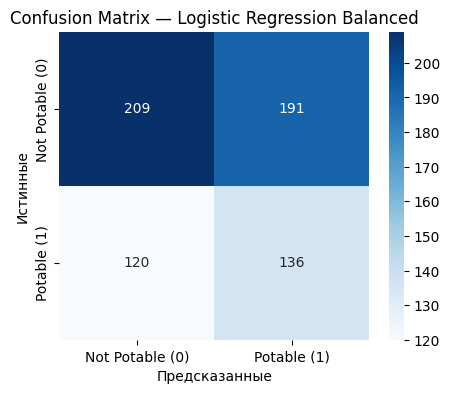


=== Random Forest Balanced ===
Precision (class=1): 0.6514
Recall (class=1)   : 0.2773
F1-score (class=1) : 0.3890
ROC-AUC            : 0.6552


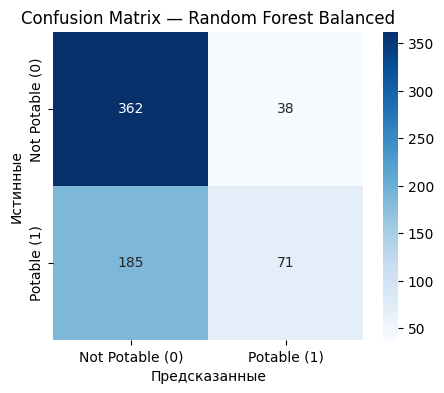

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:40:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Balanced ===
Precision (class=1): 0.5374
Recall (class=1)   : 0.4766
F1-score (class=1) : 0.5052
ROC-AUC            : 0.6214


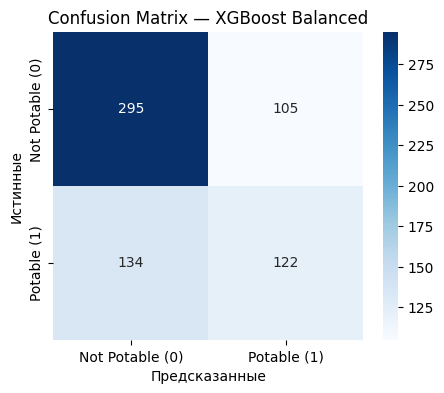

In [18]:
results_fixed = []

results_fixed.append(evaluate_model(lr_balanced, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression Balanced"))
results_fixed.append(evaluate_model(rf_balanced, X_train, X_test, y_train, y_test, "Random Forest Balanced"))
results_fixed.append(evaluate_model(xgb_balanced, X_train, X_test, y_train, y_test, "XGBoost Balanced"))

Балансировка сильно помогла линейной модели, и немного XGBoost.
Random Forest стал хуже и ещё осторожнее (recall упал с 0.30 до 0.28), чтобы сохранить высокую precision.

Сравним модели на общем графике


=== Сравнение моделей (метрики для класса 1) ===
                              precision  recall      f1  roc_auc
model                                                           
Logistic Regression Balanced     0.4159  0.5312  0.4666   0.5475
Random Forest Balanced           0.6514  0.2773  0.3890   0.6552
XGBoost Balanced                 0.5374  0.4766  0.5052   0.6214


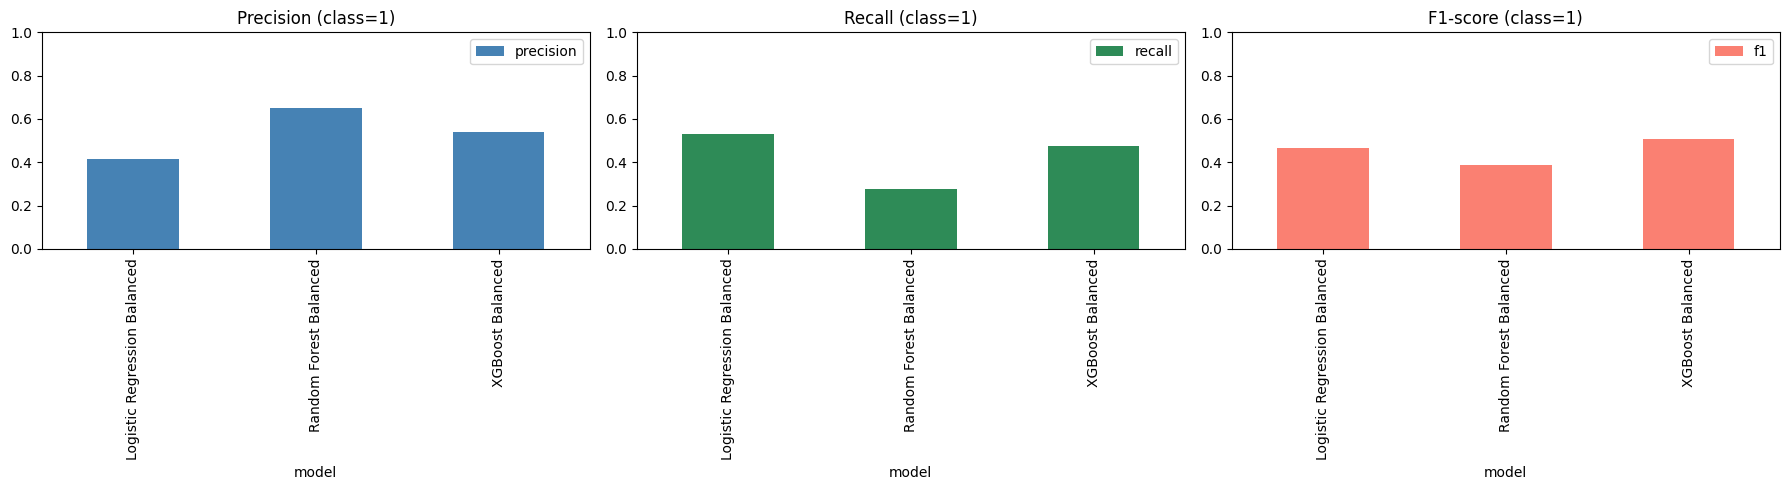

<Figure size 600x400 with 0 Axes>

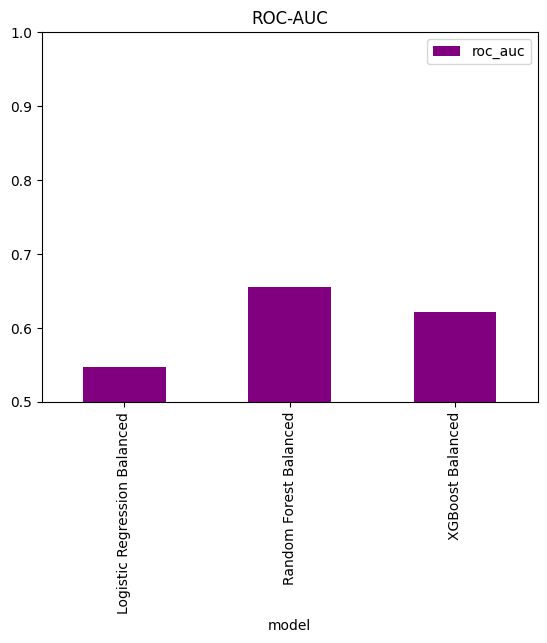

In [19]:
#Сводная таблица
results_df = pd.DataFrame(results_fixed).set_index('model')
print("\n=== Сравнение моделей (метрики для класса 1) ===")
print(results_df.round(4))

#Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_df[['precision']].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Precision (class=1)')
axes[0].set_ylim(0, 1)

results_df[['recall']].plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Recall (class=1)')
axes[1].set_ylim(0, 1)

results_df[['f1']].plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('F1-score (class=1)')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

#ROC-AUC
if 'roc_auc' in results_df.columns:
    plt.figure(figsize=(6, 4))
    results_df[['roc_auc']].plot(kind='bar', color='purple')
    plt.title('ROC-AUC')
    plt.ylim(0.5, 1.0)
    plt.show()

У RF высокий Precision, значит самая маленькая вероятность ложного определение воды, но тем не менее у RF низкий Recall, что означает, что модель много отбраковывает воду зря.  
У Logistic Regression маленький Precision - много ложных срабатываний. Самый большой Recall - находит больше всех пригодной воды.  
У XGB средние значения Precision и Recall, что делает её наилучшим кандидатом. Из-за Recall = 0.47 находит почти половину пригодной для питья воды. Precision = 0.53,что делает предсказательную модель наиболее безопасной. А также XGB имеет самый высокий показатель F1-score, что делает её идеальной моделью среди всех используемых.

**Подбор гиперпараметров для лучшей модели (по F1-score это XGBoost)**

In [20]:
#Базовая модель с балансировкой
xgb = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss'
)

#Сетка гиперпараметров
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#Поиск с фокусом на F1
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',          # оптимизируем F1
    cv=5,                  # 5-фолдовая кросс-валидация
    n_jobs=-1,             # используем все ядра
    verbose=1              # показываем прогресс
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

#Результаты
print("\nЛучшие параметры:")
print(grid_search.best_params_)
print(f"\nЛучший F1 на кросс-валидации: {grid_search.best_score_:.4f}")

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Лучший F1 на кросс-валидации: 0.5355



=== Лучшая модель XGBoost (после тюнинга) ===
Precision (class=1): 0.5079
Recall (class=1)   : 0.5039
F1-score (class=1) : 0.5059
ROC-AUC            : 0.6320


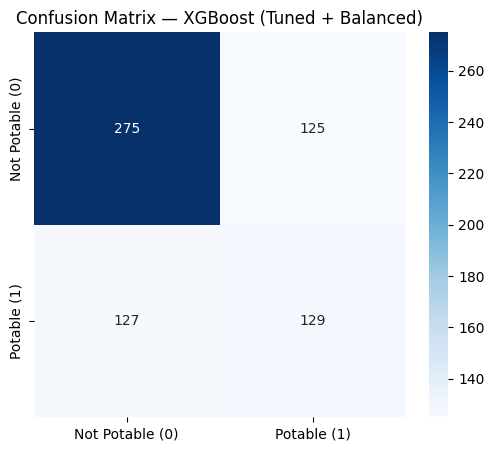

In [21]:
#Лучшая модель
best_xgb = grid_search.best_estimator_

#Предсказания
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

#Метрики
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Лучшая модель XGBoost (после тюнинга) ===")
print(f"Precision (class=1): {prec:.4f}")
print(f"Recall (class=1)   : {rec:.4f}")
print(f"F1-score (class=1) : {f1:.4f}")
print(f"ROC-AUC            : {auc:.4f}")

#Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Potable (0)', 'Potable (1)'],
            yticklabels=['Not Potable (0)', 'Potable (1)'])
plt.title('Confusion Matrix — XGBoost (Tuned + Balanced)')
plt.show()

В итоге наша лучшая модель XGBoost имеет F1-score: 0.5059, что дает понять, что наша модель достигает умеренного баланса между безопасностью и полнотой.
Примерно в половине случаев она правильно справляется с задачей для класса 1 (то есть определения питевой воды).

Сохраним наш масштабатор и лучшую модель

In [24]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_xgb, 'water_quality_model.pkl')

print("Модель и масштабатор успешно сохранены!")

Модель и масштабатор успешно сохранены!
